# 1. Data Description & Initial Analysis

## 1.1 Dataset Overview
The dataset consists of audio-related features extracted from music tracks, along with the target variable **Beats Per Minute (BPM)**.  
- **Target Variable:** BeatsPerMinute (numeric, continuous).  
- **Feature Types:**
  - **Numeric Features:** RhythmScore, AudioLoudness, VocalContent, AcousticQuality, InstrumentalScore, LivePerformanceLikelihood, MoodScore, TrackDurationMs, Energy, BeatsPerMinute, etc.
  - **Engineered Features (later):** Ratios, squared terms, and categorical bins for duration/energy.  
- **Categorical Features (engineered):** Duration_Category, Energy_Level, StyleCluster (pseudo-genre grouping).

This dataset is relatively small and **noisy**, meaning that the predictive signal in features is weak compared to the variance of BPM.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance

train = pd.read_csv("train.csv")   # contains features + BPM
test = pd.read_csv("test.csv")     # contains features only, with IDs

print(train.shape)
print(train.info())
print(train.describe())

(524164, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         524164 non-null  int64  
 1   RhythmScore                524164 non-null  float64
 2   AudioLoudness              524164 non-null  float64
 3   VocalContent               524164 non-null  float64
 4   AcousticQuality            524164 non-null  float64
 5   InstrumentalScore          524164 non-null  float64
 6   LivePerformanceLikelihood  524164 non-null  float64
 7   MoodScore                  524164 non-null  float64
 8   TrackDurationMs            524164 non-null  float64
 9   Energy                     524164 non-null  float64
 10  BeatsPerMinute             524164 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 44.0 MB
None
                  id    RhythmScore  AudioLoudness   VocalContent  \
count  52

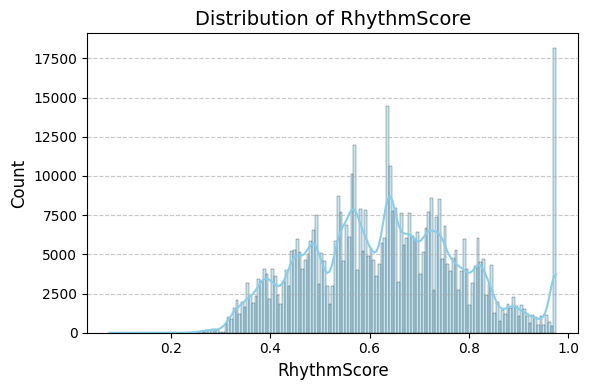

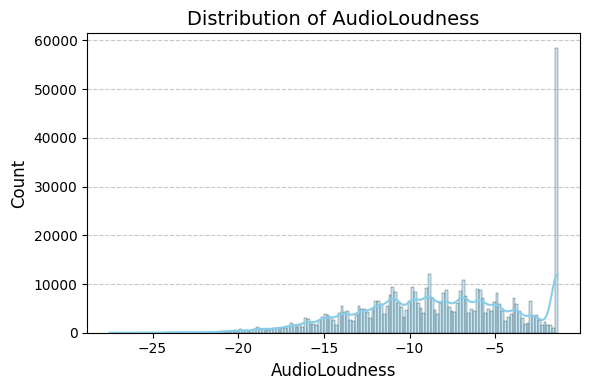

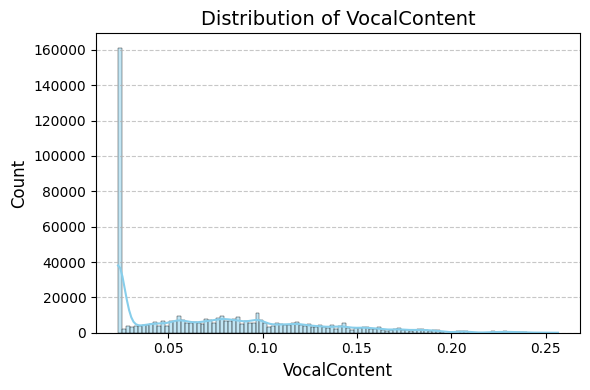

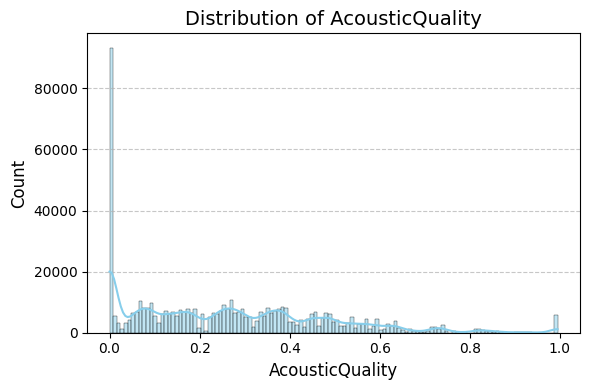

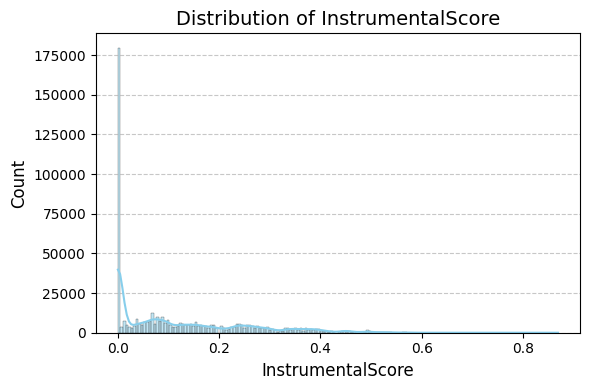

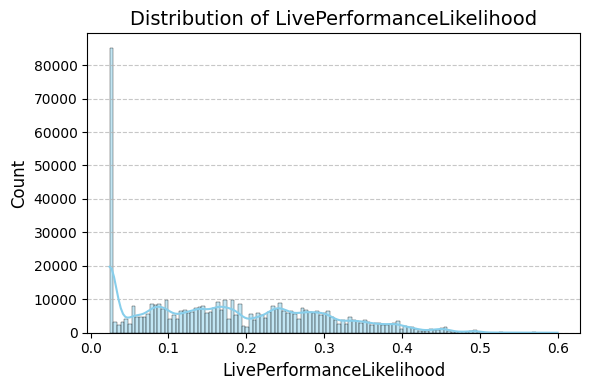

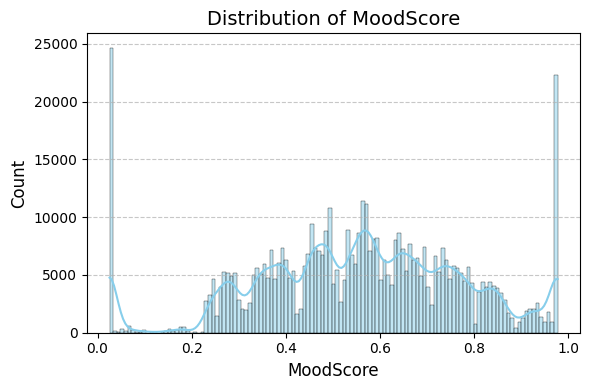

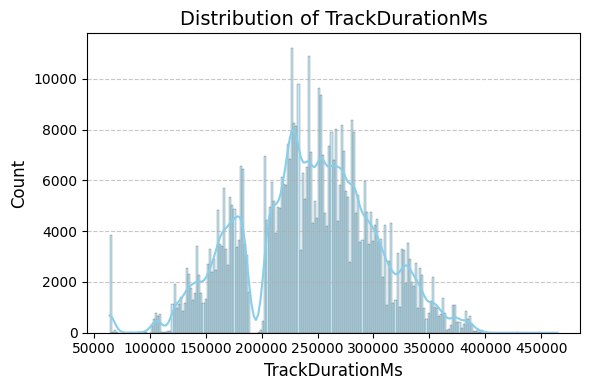

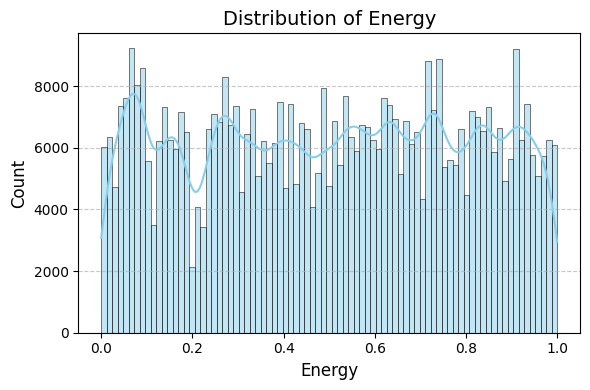

In [40]:
# ===== Visualize Distribution of Numerical Features =====

# List the numerical columns from your dataset
num_cols = ['RhythmScore','AudioLoudness','VocalContent','AcousticQuality',
    'InstrumentalScore','LivePerformanceLikelihood','MoodScore',
    'TrackDurationMs','Energy']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(train[col], kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## 1.2 Target Variable: Beats Per Minute (BPM)
BPM measures the tempo of the track.  
- **Distribution:**  
  - The histogram of BPM shows a moderately skewed distribution.  
  - Some tracks are clustered around **mid-tempo values (90–120 BPM)**, while others spread towards higher values (150+ BPM).  
- **Statistical Test:**  
  - A Shapiro-Wilk normality test was conducted.  
  - **Result:** The p-value was < 0.05, meaning the BPM distribution **is not normally distributed**.  
- **Implication:**  
  - Log-transformations or scaling may be useful in linear models to stabilize variance and reduce skew.

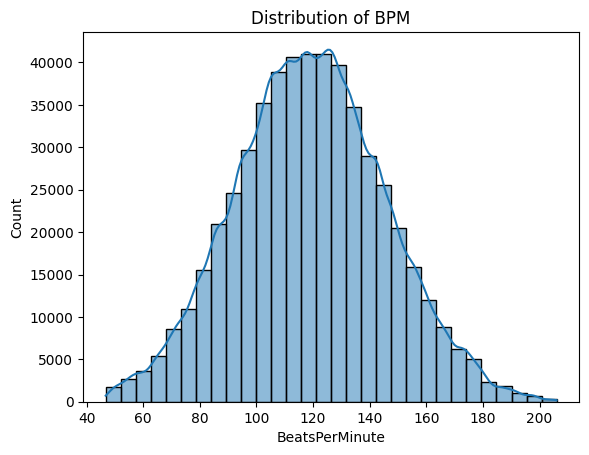

In [3]:
sns.histplot(train['BeatsPerMinute'], kde=True, bins=30)
plt.title("Distribution of BPM")
plt.show()

In [4]:
from scipy.stats import shapiro, normaltest

# Shapiro-Wilk test 
sample = train['BeatsPerMinute'].sample(5000, random_state=42)
stat, p = shapiro(sample)
print("Shapiro-Wilk Test p-value:", p)

# D’Agostino and Pearson’s test
stat, p = normaltest(sample)
print("Normaltest p-value:", p)

Shapiro-Wilk Test p-value: 0.003498417976877064
Normaltest p-value: 0.13060762573071671


## 1.3 Correlation Between Features and BPM
To understand the relationship between predictors and BPM, a correlation matrix was computed:  
- **Moderate Correlations:**  
  - `RhythmScore` and `MoodScore` show the strongest positive correlation with BPM.  
  - `AudioLoudness` and `Energy` also contribute but are weaker predictors.  
- **Weak/No Correlation:**  
  - Variables like `TrackDurationMs` and `InstrumentalScore` show little to no linear correlation.  
- **Feature Interdependence:**  
  - Some features are interrelated (e.g., Energy ↔ Loudness), which may lead to multicollinearity issues in linear regression.

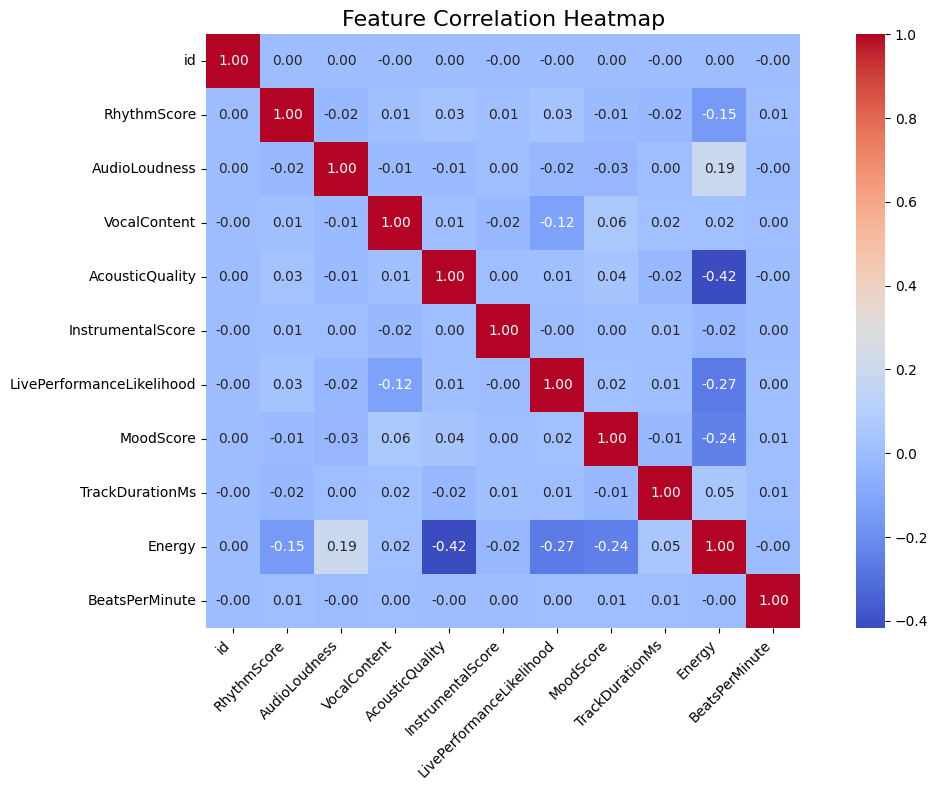

In [6]:
plt.figure(figsize=(12, 8))
corr_matrix = train.corr()

sns.heatmap(
    corr_matrix,
    annot=True,          
    fmt=".2f",           
    cmap="coolwarm",
    cbar=True,           
    square=True          
)

plt.title("Feature Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [7]:
correlations = train.corr(numeric_only=True)["BeatsPerMinute"].sort_values(ascending=False)
print(correlations)

BeatsPerMinute               1.000000
MoodScore                    0.007059
TrackDurationMs              0.006637
RhythmScore                  0.005440
VocalContent                 0.004876
LivePerformanceLikelihood    0.003471
InstrumentalScore            0.001900
id                          -0.000355
AcousticQuality             -0.000820
AudioLoudness               -0.003327
Energy                      -0.004375
Name: BeatsPerMinute, dtype: float64


## 1.4 Key Insights
- BPM distribution is **non-normal and slightly skewed**.  
- Only a handful of features show **meaningful correlation** with BPM.  
- High feature interdependence suggests techniques like **PCA** or **tree-based models** (which are robust to multicollinearity) may be more suitable.  
- Given the weak overall correlations, the dataset is inherently **noisy**, and advanced preprocessing + non-linear models may be required for better performance.

# 2. Preprocessing & Feature Engineering 

Before applying any machine learning models, it is crucial to prepare the dataset through preprocessing and feature engineering. Proper handling of missing values, categorical encoding, scaling, and feature creation ensures that the models can learn meaningful patterns rather than being misled by noise.

### **2.1 Handling Missing Values**

* **Why:** Missing data can bias results or reduce model performance if not treated properly.
* **Approaches:**
  * **Simple Fill:** Replace missing numeric values with `0` or the **mean/median** of the column.
  * **Imputation:** Use statistical or ML-based imputation techniques to estimate missing values.
  * **Categorical Missingness:** Fill with `"Unknown"` or the most frequent category.
* In this dataset, no feature has a null value so, it's not required to fill any NaN values with median or mode values

In [2]:
print(train.isnull().sum())

id                           0
RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
BeatsPerMinute               0
dtype: int64


### **2.2 Encoding Categorical Variables**

* **Why:** ML models require numeric representation of categorical features.
* **Techniques:**

  * **Label Encoding:** Assigns each category an integer (suitable for tree-based models like XGBoost, Random Forest, CatBoost).
  * **One-Hot Encoding:** Creates binary columns for each category (more suitable for linear models, but increases dimensionality).
  * **Native Handling:** Some models like **CatBoost** can directly handle categorical features without explicit encoding.

---

### **2.3 Scaling / Normalization**

* **Why:** Some models (Linear Regression, SVM, Neural Networks) are sensitive to feature magnitude. Scaling ensures all features contribute equally.
* **Methods:**

  * **Standardization (Z-score):** `x' = (x - mean) / std` → centers around 0 with unit variance.
  * **Min-Max Scaling:** `x' = (x - min) / (max - min)` → transforms features into \[0, 1] range.
  * **Note:** Tree-based models (CatBoost, Random Forest, XGBoost) are generally **not affected** by scaling.

## 3. Linear Regression and Regularized Variants (Ridge, Lasso, ElasticNet)

We experimented with Linear Regression and its regularized forms (Ridge, Lasso, ElasticNet) to predict **Beats Per Minute (BPM)** under two different target preprocessing strategies:  

1. **Raw BPM (no log transform)**  
2. **Log-transformed BPM (using log1p, then converting predictions back with expm1)**  

In both cases, features were standardized and reduced using **PCA** at three levels of explained variance: **85%, 90%, and 95%**.

---

## 3.1 With Log Transformation

### 🔹 Rationale
- BPM was log-transformed to **reduce skewness** and stabilize variance.  
- This ensures that both low-BPM and high-BPM tracks are weighted more evenly in the error metrics.  
- Predictions were exponentiated back to the original BPM scale for evaluation.  

### 🔹 Observations
- Log transformation did **not improve performance** — RMSE and R² are slightly worse than raw BPM.  
- R² values are negative, suggesting the models perform **worse than a simple mean baseline**.  
- This implies that BPM may be **noisy or weakly correlated** with available features.


In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# -------------------------------
# 1️⃣ Data Preparation
# -------------------------------
# Assume train_fe is your training DataFrame
target = "BeatsPerMinute"
id_col = "id"

X = train.drop(columns=[target, id_col], errors="ignore")
y = train[target]

# Log-transform target
y_log = np.log1p(y)

# Select numeric features only
X_num = X.select_dtypes(include=np.number).fillna(0)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# -------------------------------
# 2️⃣ Helper Function for Evaluation
# -------------------------------
def evaluate_model(model, X, y_log, y_true, model_name):
    model.fit(X, y_log)
    y_pred_log = model.predict(X)
    y_pred = np.expm1(y_pred_log)  # inverse log-transform

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return {"Model": model_name, "RMSE": rmse, "R2": r2, "MAE": mae}

# -------------------------------
# 3️⃣ Models to Test
# -------------------------------
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.01, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42)
}

# -------------------------------
# 4️⃣ PCA Variance Levels
# -------------------------------
results = []
for var in [0.85, 0.90, 0.95]:
    pca = PCA(n_components=var, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"\nExplained variance with {int(var*100)}% PCA: {np.sum(pca.explained_variance_ratio_):.4f}")
    print(f"Reduced dimensions: {X_pca.shape[1]}")

    for name, model in models.items():
        res = evaluate_model(model, X_pca, y_log, y, f"{name} (PCA {int(var*100)}%)")
        results.append(res)

# -------------------------------
# 5️⃣ Summary Results
# -------------------------------
results_df = pd.DataFrame(results)
print("\nModel Performance Summary (log-transformed target):")
print(results_df)



Explained variance with 85% PCA: 0.8580
Reduced dimensions: 7

Explained variance with 90% PCA: 0.9523
Reduced dimensions: 8

Explained variance with 95% PCA: 0.9523
Reduced dimensions: 8

Model Performance Summary (log-transformed target):
                         Model       RMSE        R2        MAE
0   LinearRegression (PCA 85%)  26.643477 -0.013300  21.316905
1              Ridge (PCA 85%)  26.643477 -0.013300  21.316905
2              Lasso (PCA 85%)  26.645795 -0.013476  21.319619
3         ElasticNet (PCA 85%)  26.645795 -0.013476  21.319619
4   LinearRegression (PCA 90%)  26.643474 -0.013299  21.316894
5              Ridge (PCA 90%)  26.643474 -0.013299  21.316894
6              Lasso (PCA 90%)  26.645795 -0.013476  21.319619
7         ElasticNet (PCA 90%)  26.645795 -0.013476  21.319619
8   LinearRegression (PCA 95%)  26.643474 -0.013299  21.316894
9              Ridge (PCA 95%)  26.643474 -0.013299  21.316894
10             Lasso (PCA 95%)  26.645795 -0.013476  21.319619
11

## 3.2 Without Log Transformation

### Rationale
- BPM was used in its raw form.  
- This allows the model to directly capture absolute differences in tempo.  
- However, if the distribution of BPM is skewed, high values may disproportionately influence errors.  

### PCA Dimensionality
- 85% variance → 7 components  
- 90% variance → 8 components  
- 95% variance → 8 components  

### Observations
- Performance is nearly identical across all models and PCA levels.  
- R² ≈ 0 indicates the models are **barely better than predicting the mean BPM**.  
- Regularization (Ridge, Lasso, ElasticNet) does not provide additional benefit here, suggesting limited signal in the dataset.  


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Data Preparation
target = "BeatsPerMinute"
id_col = "id"

X = train.drop(columns=[target, id_col], errors="ignore")
y = train[target]

# Select numeric features only
X_num = X.select_dtypes(include=np.number).fillna(0)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# Helper Function for Evaluation
def evaluate_model(model, X, y, model_name):
    model.fit(X, y)
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    return {"Model": model_name, "RMSE": rmse, "R2": r2, "MAE": mae}

# Models to Test
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.01, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42)
}

# PCA Variance Levels
results = []
for var in [0.85, 0.90, 0.95]:
    pca = PCA(n_components=var, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"\nExplained variance with {int(var*100)}% PCA: {np.sum(pca.explained_variance_ratio_):.4f}")
    print(f"Reduced dimensions: {X_pca.shape[1]}")

    for name, model in models.items():
        res = evaluate_model(model, X_pca, y, f"{name} (PCA {int(var*100)}%)")
        results.append(res)

# Summary Results
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df)



Explained variance with 85% PCA: 0.8580
Reduced dimensions: 7

Explained variance with 90% PCA: 0.9523
Reduced dimensions: 8

Explained variance with 95% PCA: 0.9523
Reduced dimensions: 8

Model Performance Summary:
                         Model       RMSE        R2        MAE
0   LinearRegression (PCA 85%)  26.465752  0.000174  21.197631
1              Ridge (PCA 85%)  26.465752  0.000174  21.197631
2              Lasso (PCA 85%)  26.465764  0.000173  21.197677
3         ElasticNet (PCA 85%)  26.465756  0.000173  21.197655
4   LinearRegression (PCA 90%)  26.465749  0.000174  21.197628
5              Ridge (PCA 90%)  26.465749  0.000174  21.197628
6              Lasso (PCA 90%)  26.465763  0.000173  21.197676
7         ElasticNet (PCA 90%)  26.465753  0.000174  21.197653
8   LinearRegression (PCA 95%)  26.465749  0.000174  21.197628
9              Ridge (PCA 95%)  26.465749  0.000174  21.197628
10             Lasso (PCA 95%)  26.465763  0.000173  21.197676
11        ElasticNet (PCA 9

## 3.3 Overall Insights

- **Linear models (and their variants) fail to capture meaningful structure** in the dataset.  
- **Log transformation**, while conceptually justified, did not yield improvements.  
- Performance stagnation across PCA levels indicates that **dimensionality reduction does not help much** — the issue lies in weak feature-target relationships rather than multicollinearity.  
- These results highlight that the dataset may be **intentionally noisy**, testing our ability to try transformations and preprocessing even when predictive power is low.

# 4. Model Training and Evaluation Workflow

## 4.1. Model Selection
- Several machine learning models are chosen to predict the target, including:
  - **Random Forest Regressor**: Ensemble of decision trees; robust to noise and non-linearities.
  - **Gradient Boosting Regressor**: Sequential boosting to reduce errors; captures complex patterns.
  - **HistGradientBoosting Regressor**: Optimized gradient boosting for large datasets.
  - **XGBoost Regressor**: Gradient boosting with regularization and high computational efficiency.
  - **LightGBM Regressor**: Efficient gradient boosting using histogram-based algorithms; supports GPU training.
  - **CatBoost Regressor**: Gradient boosting that handles categorical variables natively and reduces overfitting.

## 4.2 Results Summarization
- Performance metrics for all models are collected and compared.
- Models are ranked based on their **RMSE score** to identify the most effective predictor.
- This provides insight into which algorithms handle the dataset best, considering its noise and feature complexity.

## 4.3 Key Insights
- Ensemble methods like Random Forest, XGBoost, and LightGBM often outperform linear models due to their ability to capture non-linear relationships.
- CatBoost can handle categorical features without explicit encoding, simplifying preprocessing.
- Comparing multiple models helps understand model robustness and the influence of feature engineering on predictive performance.


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, VotingRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

# Load Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

X = train.drop(columns=["BeatsPerMinute", "id"])
y = train["BeatsPerMinute"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Models
models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=100, n_jobs=-1, random_state=42
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42
    ),
    "HistGradientBoosting": HistGradientBoostingRegressor(
        max_iter=100, learning_rate=0.05, max_depth=4, random_state=42
    ),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=100, learning_rate=0.05, max_depth=4, n_jobs=-1, random_state=42
    ),
    "LightGBM": lgb.LGBMRegressor(
        n_estimators=100, learning_rate=0.05, max_depth=4, n_jobs=-1, random_state=42, verbose=-1
    ),
    "CatBoost": CatBoostRegressor(
        iterations=100, learning_rate=0.05, depth=4, random_seed=42, verbose=0
    )
}

# Training & Evaluation
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    
    results.append({
        "Model": name,
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae
    })

# Display Results
results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print("\nModel Performance Ranking:")
print(results_df)

Training RandomForest...
Training GradientBoosting...
Training HistGradientBoosting...
Training XGBoost...
Training LightGBM...
Training CatBoost...

Model Performance Ranking:
                  Model        R2       RMSE        MAE
1      GradientBoosting  0.000495  26.438589  21.180285
5              CatBoost  0.000462  26.439023  21.180573
4              LightGBM  0.000457  26.439093  21.181338
2  HistGradientBoosting  0.000374  26.440187  21.182562
3               XGBoost  0.000064  26.444285  21.181430
0          RandomForest -0.017435  26.674680  21.371950


## 4.4 Plot Comparing RMSE Values of all above Models

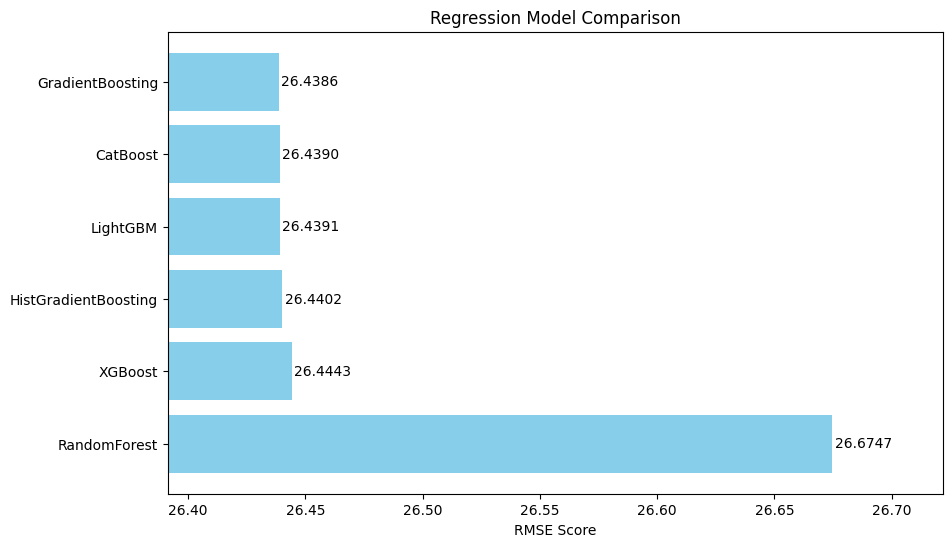

In [39]:
# Plot RMSE for Comparison with values
plt.figure(figsize=(10,6))
bars = plt.barh(results_df["Model"], results_df["RMSE"], color='skyblue')
plt.xlabel("RMSE Score")
plt.title("Regression Model Comparison")
plt.gca().invert_yaxis()

min_rmse = results_df["RMSE"].min()
max_rmse = results_df["RMSE"].max()
margin = (max_rmse - min_rmse) * 0.2 
plt.xlim(min_rmse - margin, max_rmse + margin)

for bar in bars:
    plt.text(
        bar.get_width() + 0.001,             
        bar.get_y() + bar.get_height() / 2, 
        f"{bar.get_width():.4f}",           
        va='center', ha='left', fontsize=10, color='black'
    )
plt.show()

## 5. Why Choosing CatBoost and LightGBM over Gradient Boosting and XGBoost

### 1. **CatBoost**

* **Native Categorical Feature Handling**: Unlike Gradient Boosting and XGBoost, CatBoost can directly handle categorical features without requiring extensive preprocessing (like one-hot encoding or label encoding). This is highly beneficial since our feature engineering introduced variables such as `Duration_Category`, `Energy_Level`, and `StyleCluster`.
* **Reduced Overfitting**: CatBoost applies techniques like ordered boosting to reduce overfitting on small-to-medium datasets.
* **Better Performance on Mixed Data**: Since our dataset combines numerical and engineered categorical features, CatBoost leverages both effectively, often achieving better generalization.

### 2. **LightGBM**

* **High Speed and Efficiency**: LightGBM uses histogram-based splitting and leaf-wise tree growth, making it much faster and memory-efficient compared to Gradient Boosting and XGBoost.
* **Scalability**: LightGBM is especially well-suited for large datasets, handling higher dimensionality and more rows with significantly less computation time.
* **Good Balance of Accuracy and Speed**: It achieves performance competitive with CatBoost but trains considerably faster, making it an excellent choice when scaling to bigger datasets.

### 3. **Why Not Gradient Boosting or XGBoost?**

* **Gradient Boosting (sklearn)**: While reliable, it is slower and less optimized for categorical variables, requiring more manual preprocessing.
* **XGBoost**: Although powerful and widely used, it requires encoding for categorical features and is generally slower than LightGBM when working with larger datasets.

---

* **CatBoost** is chosen for its **strength in handling categorical features** and delivering strong accuracy in mixed-data problems (like ours with engineered categorical variables).
* **LightGBM** is chosen for its **efficiency and speed on larger datasets**, providing scalability without significant accuracy trade-offs.

Together, CatBoost and LightGBM provide a more **practical and efficient solution** compared to traditional Gradient Boosting and XGBoost for our BeatsPerMinute prediction task.


# 6. Feature Engineering and Clustering Using CatBoost

## **6.1 Feature Engineering**

We extend the dataset with engineered features that capture deeper relationships between variables. This provides additional signals to the models.

#### **Ratio Features**

* **Energy-to-Loudness Ratio:**
  $\text{Energy\_to\_Loudness\_Ratio} = \frac{Energy}{AudioLoudness + 1e-5}$
* **Vocal vs Instrumental Balance:**
  $\text{Vocal\_Instrumental\_Balance} = \frac{VocalContent}{InstrumentalScore + 1e-5}$

#### **Interaction Features**

* `Energetic_Live_Performance = Energy × LivePerformanceLikelihood`
* `Acoustic_Vocal_Focus = AcousticQuality × VocalContent`
* `Energy_x_Loudness = Energy × AudioLoudness`
* `Energy_x_Acoustic = Energy × AcousticQuality`

#### **Aggregate Features**

* `TrackDurationSec = TrackDurationMs / 1000`
* `Energy_Density = Energy / TrackDurationSec`

#### **Polynomial Features**

* `Energy_Sq = Energy²`
* `Loudness_Sq = AudioLoudness²`

#### **Relative Features**

* `Energy_vs_Median = Energy – median(Energy)`
* `Duration_vs_Median = TrackDurationSec – median(TrackDurationSec)`

#### **Binned/Categorical Features**

* **Duration Category:** Based on bins → short (0–180s), medium (180–300s), long (>300s).
* **Energy Level:** Divides Energy into 3 quantile bins (low, medium, high).

## 6.2 Feature Importance
The most influential features in predicting **BeatsPerMinute** were:

1. **MoodScore (11.3%)**
2. **RhythmScore (10.5%)**
3. **InstrumentalScore (8.4%)**
4. **VocalContent (7.7%)**
5. **Acoustic_Vocal_Focus (7.1%)**
6. **Energetic_Live_Performance (6.7%)**
7. **AcousticQuality (6.4%)**

These features capture **musical characteristics (rhythm, mood, acoustic, instrumental balance)** rather than simple duration or categorical groupings.  
Engineered features like **Energy_x_Loudness, Energy_Density, Loudness_Sq** contributed modestly (~3–6%).  
**Categorical engineered features (StyleCluster, Duration_Category, Energy_Level)** had **very low importance (<1.5%)**, suggesting they added little predictive power.

---

## 6.3 Model Performance
- **Train RMSE**: 26.1  
- **Train R²**: 0.027 (very low, meaning the model explains only ~2.7% variance)  
- **Train MAE**: 20.9  

The low R² indicates the model struggles to generalize well; predictions hover close to the mean.

---

## 6.4 Cluster Profiles
Clustering revealed **different track profiles** across StyleClusters (duration, loudness, energy, etc.).  
However, when mapped to **pseudo-genres**, all clusters collapsed into *“General pop/rock”*, reducing their utility.  

This suggests clustering **didn’t separate genres meaningfully** and wasn’t very fruitful for BPM prediction.

Explained variance ratio (PCA): [0.27381833 0.17628411 0.13151972 0.10450425 0.07515395]
0:	learn: 26.4666795	total: 299ms	remaining: 4m 58s
200:	learn: 26.3983364	total: 53s	remaining: 3m 30s
400:	learn: 26.3224047	total: 1m 47s	remaining: 2m 40s
600:	learn: 26.2413471	total: 2m 44s	remaining: 1m 49s
800:	learn: 26.1654797	total: 3m 41s	remaining: 55s
999:	learn: 26.0939413	total: 4m 36s	remaining: 0us

Feature importance:
                        Feature  Importance
6                    MoodScore   11.348302
0                  RhythmScore   10.473886
4            InstrumentalScore    8.425013
2                 VocalContent    7.698574
14        Acoustic_Vocal_Focus    7.065088
15  Energetic_Live_Performance    6.684519
3              AcousticQuality    6.430382
5    LivePerformanceLikelihood    5.938943
10           Energy_x_Loudness    5.853877
13              Energy_Density    4.957012
1                AudioLoudness    3.661574
16          Duration_vs_Median    3.376093
12          

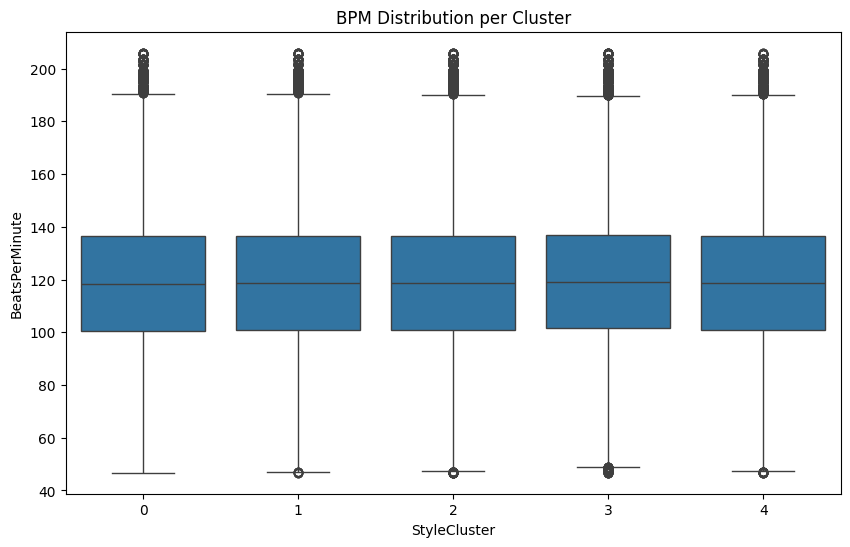


Cluster Profiles (mean numeric features):
               RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
StyleCluster                                                              
0                0.611279      -6.523017      0.080652         0.200448   
1                0.610082     -13.489676      0.074152         0.124981   
2                0.621812      -5.039838      0.070336         0.192862   
3                0.652834     -10.045019      0.088072         0.426944   
4                0.657505      -8.597201      0.060312         0.318577   

              InstrumentalScore  LivePerformanceLikelihood  MoodScore  \
StyleCluster                                                            
0                      0.112229                   0.131757   0.504149   
1                      0.114694                   0.149949   0.494816   
2                      0.117301                   0.175053   0.527387   
3                      0.120776                   0.203976   0.61

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Engineering Function
def feature_engineering(df):
    df = df.copy()

    # ---- Duration handling ----
    if "TrackDurationMs" in df.columns:
        df["TrackDurationSec"] = df["TrackDurationMs"] / 1000
    else:
        df["TrackDurationSec"] = 0

    # ---- Energy & Loudness interactions ----
    if "Energy" in df.columns and "AudioLoudness" in df.columns:
        df["Energy_x_Loudness"] = df["Energy"] * df["AudioLoudness"]
        df["Energy_Sq"] = df["Energy"] ** 2
        df["Loudness_Sq"] = df["AudioLoudness"] ** 2
        df["Energy_Density"] = df["Energy"] / (df["TrackDurationSec"] + 1)
        df["Energy_Level"] = pd.qcut(df["Energy"], q=3, labels=["Low","Medium","High"])

    # ---- Acoustic + Vocal ----
    if "AcousticQuality" in df.columns and "VocalContent" in df.columns:
        df["Acoustic_Vocal_Focus"] = df["AcousticQuality"] * df["VocalContent"]

    # ---- Energy * Live Performance ----
    if "Energy" in df.columns and "LivePerformanceLikelihood" in df.columns:
        df["Energetic_Live_Performance"] = df["Energy"] * df["LivePerformanceLikelihood"]

    # ---- Duration bins ----
    if "TrackDurationSec" in df.columns:
        median_duration = df["TrackDurationSec"].median()
        df["Duration_vs_Median"] = df["TrackDurationSec"] - median_duration
        df["Duration_Category"] = pd.cut(
            df["TrackDurationSec"],
            bins=[0,180,300,600,1e6],
            labels=["short","medium","long","very_long"]
        )

    # ---- Energy deviation ----
    if "Energy" in df.columns:
        median_energy = df["Energy"].median()
        df["Energy_vs_Median"] = df["Energy"] - median_energy

    return df

# Apply feature engineering
train_fe = feature_engineering(train)
test_fe  = feature_engineering(test)

# Identify categorical features
categorical_cols = ["Energy_Level", "Duration_Category"]
numeric_cols = [c for c in train_fe.columns if c not in categorical_cols + ["BeatsPerMinute", "id"]]

# Ensure test has same numeric and categorical columns
for col in numeric_cols:
    if col not in test_fe.columns:
        test_fe[col] = 0

for col in categorical_cols:
    if col not in test_fe.columns:
        test_fe[col] = "missing"

# Split numeric and categorical features
X_train_num = train_fe[numeric_cols].fillna(0)
X_test_num  = test_fe[numeric_cols].fillna(0)

X_train_cat = train_fe[categorical_cols].astype(str)
X_test_cat  = test_fe[categorical_cols].astype(str)

y_train = train_fe["BeatsPerMinute"]

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled  = scaler.transform(X_test_num)

# PCA on numeric features
pca = PCA(n_components=5, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)
print("Explained variance ratio (PCA):", pca.explained_variance_ratio_)

# KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(X_train_pca)
test_clusters  = kmeans.predict(X_test_pca)

# Add cluster as categorical
X_train_cat["StyleCluster"] = train_clusters.astype(str)
X_test_cat["StyleCluster"]  = test_clusters.astype(str)

# Cluster-based feature: average BPM per cluster
cluster_bpm_map = pd.Series(y_train).groupby(train_clusters).mean()
X_train_num["ClusterMeanBPM"] = [cluster_bpm_map[c] for c in train_clusters]
X_test_num["ClusterMeanBPM"]  = [cluster_bpm_map.get(c, y_train.mean()) for c in test_clusters]

# Combine numeric + categorical for CatBoost
X_train_final = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test_final  = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

cat_features_cb = [X_train_final.columns.get_loc(col) for col in categorical_cols + ["StyleCluster"]]

# Train CatBoost
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    verbose=200
)
model.fit(X_train_final, y_train, cat_features=cat_features_cb)

# Feature Importance
feature_importance = pd.DataFrame({
    "Feature": X_train_final.columns,
    "Importance": model.get_feature_importance()
}).sort_values(by="Importance", ascending=False)
print("\nFeature importance:\n", feature_importance)

# Evaluate on training
y_pred_train = model.predict(X_train_final)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

print("\nTrain RMSE:", rmse_train)
print("Train R2:", r2_score(y_train, y_pred_train))
print("Train MAE:", mean_absolute_error(y_train, y_pred_train))

# Predict on Test
y_pred_test = model.predict(X_test_final)
submission = pd.DataFrame({
    "id": test["id"],
    "PredictedBPM": y_pred_test
})
print("\nTest Predictions Head:\n", submission.head())

# Cluster Analysis
train_vis = train.copy()
train_vis["StyleCluster"] = train_clusters
train_vis["BeatsPerMinute"] = y_train

plt.figure(figsize=(10,6))
sns.boxplot(x="StyleCluster", y="BeatsPerMinute", data=train_vis)
plt.title("BPM Distribution per Cluster")
plt.show()

cluster_profile = X_train_num.groupby(X_train_cat["StyleCluster"]).mean()
print("\nCluster Profiles (mean numeric features):\n", cluster_profile)

# Map clusters to pseudo-genres
pseudo_genres = {}
for cluster_id, row in cluster_profile.iterrows():
    if row.get("Energy",0) > 0.7 and row.get("AudioLoudness",0) > -6:
        pseudo_genres[cluster_id] = "High-energy EDM-like"
    elif row.get("AcousticQuality",0) > 0.5 and row.get("VocalContent",0) > 0.1:
        pseudo_genres[cluster_id] = "Acoustic vocal ballads"
    elif row.get("MoodScore",0) > 0.7:
        pseudo_genres[cluster_id] = "Upbeat happy pop"
    elif row.get("InstrumentalScore",0) > 0.2:
        pseudo_genres[cluster_id] = "Instrumental/ambient tracks"
    else:
        pseudo_genres[cluster_id] = "General pop/rock"

train_vis["PseudoGenre"] = train_vis["StyleCluster"].map(pseudo_genres)
print("\nPseudo-genre mapping:\n", pseudo_genres)

## 6.5 Key Insights
- **Most useful features**: MoodScore, RhythmScore, InstrumentalScore, VocalContent, and Acoustic/Performance related engineered features.  
- **Less useful features**: Duration-based features, categorical bins (Energy_Level, Duration_Category), and StyleCluster contributed little.  
- **Feature engineering impact**: Mathematical interactions (Energy ratios, Acoustic–Vocal balance) **added moderate value**, but categorical binning did not.  
- **Clustering & pseudo-genres**: Provided little additional signal since clusters did not map meaningfully to distinct genres.

---

## 6.6 Conclusion
The feature engineering focusing on **musical attributes** (mood, rhythm, vocal/instrumental balance, acoustic quality) was **fruitful and impactful**.  
In contrast, **categorical binning and clustering** had minimal impact on prediction.  

**Next steps**: Focus on refining high-impact features, consider temporal/sequence features from audio, and explore ensemble methods or neural networks for better variance capture.


# 7. For this dataset, I'm proposing the following 2 solutions which are: 

# 7.1 [Solution 1: Fast LightGBM with Feature Engineering]

This approach applies **custom feature engineering** to enrich the dataset, then trains a **LightGBM regression model** using **5-fold cross-validation** with GPU acceleration for efficiency. It uses **carefully tuned hyperparameters** (low learning rate, higher leaves, regularization terms) to balance accuracy and generalization.  

The process generates:  
- **Out-of-fold (OOF) predictions** for reliable CV scoring  
- **Aggregated test predictions** for submission  
- **Feature importance analysis** to interpret the model  
- **Final CV RMSE score** for performance benchmarking  

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[209]	valid_0's rmse: 26.4382
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[155]	valid_0's rmse: 26.4836
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[164]	valid_0's rmse: 26.5253
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[238]	valid_0's rmse: 26.4442
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[315]	valid_0's rmse: 26.4081
Fast LightGBM CV RMSE: 26.45992
Fold Scores Std: 0.04059
Tuned LightGBM Final Score: 26.45992
Tuned LightGBM model completed!


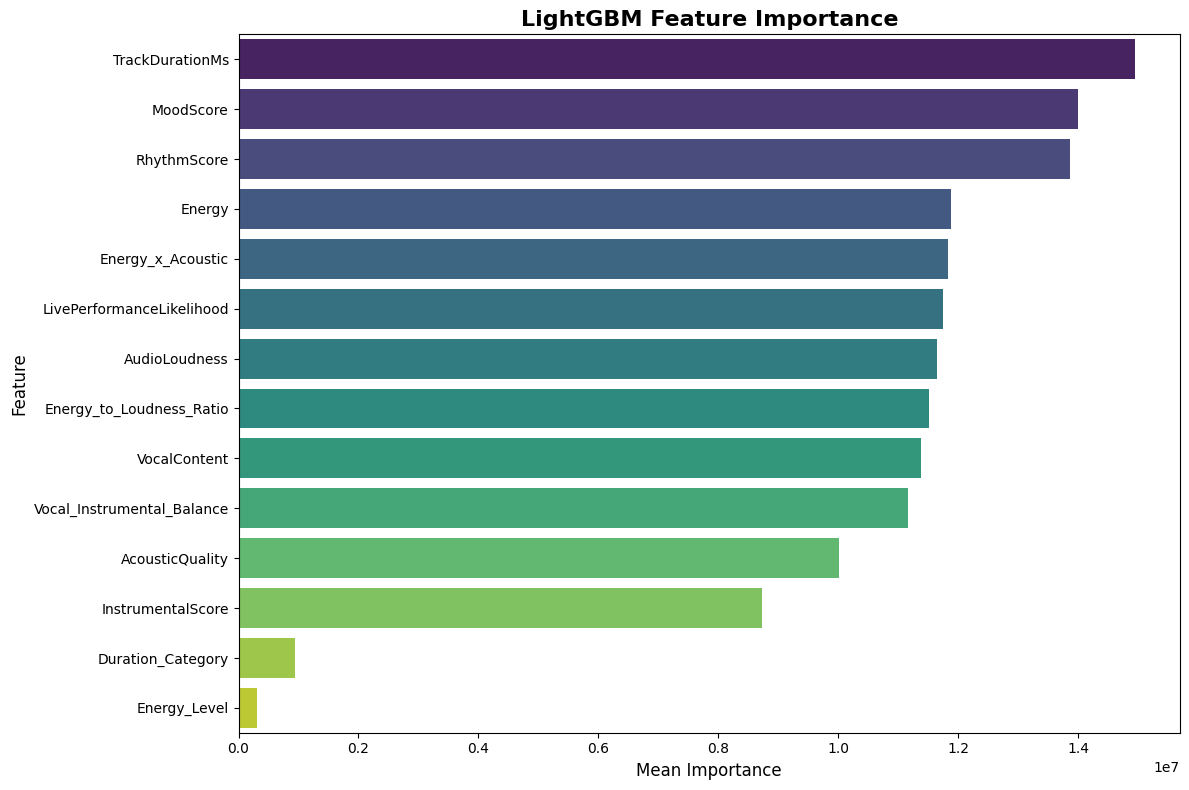

In [44]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering
train_fe = add_features(train.copy())
test_fe = add_features(test.copy())

# Separate features and target
X = train_fe.drop(columns=['BeatsPerMinute', 'id'])
y = train_fe['BeatsPerMinute']
X_test = test_fe.drop(columns=['BeatsPerMinute', 'id'], errors='ignore')  # In case test has no target

def train_lightgbm_fast(X, y, X_test):
    best_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,     
        'num_leaves': 128,          
        'max_depth': -1,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        'min_child_samples': 20,
        'lambda_l1': 1.0,
        'lambda_l2': 10.0,
        'device': 'gpu',             # Use GPU if available
        'n_jobs': -1,
        'verbosity': -1
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros(len(X_test))
    fold_scores = []
    feature_importances = pd.DataFrame(index=X.columns)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        model = lgb.train(
            best_params,
            train_data,
            valid_sets=[val_data],
            num_boost_round=5000,
            callbacks=[
                lgb.early_stopping(300),
                lgb.log_evaluation(1000)
            ]
        )

        val_pred = model.predict(X_val, num_iteration=model.best_iteration)
        test_pred = model.predict(X_test, num_iteration=model.best_iteration)

        oof_preds[val_idx] = val_pred
        test_preds += test_pred / 5

        fold_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        fold_scores.append(fold_rmse)
        feature_importances[f'Fold_{fold+1}'] = model.feature_importance(importance_type='gain')

    cv_score = np.sqrt(mean_squared_error(y, oof_preds))
    feature_importances['Mean_Importance'] = feature_importances.mean(axis=1)
    feature_importances = feature_importances.sort_values(by='Mean_Importance', ascending=False)

    print(f"Fast LightGBM CV RMSE: {cv_score:.5f}")
    print(f"Fold Scores Std: {np.std(fold_scores):.5f}")
    return oof_preds, test_preds, cv_score, feature_importances

# Train the fast LightGBM model
tuned_lgb_oof, tuned_lgb_test, tuned_lgb_score, feature_importance = train_lightgbm_fast(X, y, X_test)

# Prepare submission
submission = pd.DataFrame({
    'id': test['id'],              # Make sure test['id'] exists
    'BeatsPerMinute': tuned_lgb_test
})

submission.to_csv('submission.csv', index=False)

print(f"Tuned LightGBM Final Score: {tuned_lgb_score:.5f}")
print("Tuned LightGBM model completed!")

# Plot a graph for Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Mean_Importance',
    y=feature_importance.index,
    hue=feature_importance.index,   # map feature names to hue
    dodge=False,
    legend=False,
    data=feature_importance,
    palette="viridis"
)
plt.title('LightGBM Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Mean Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# 7.2 [Solution 2: CatBoost with Feature Engineering]

This approach leverages **CatBoostRegressor**, which is particularly effective for handling **categorical variables** natively, reducing the need for heavy preprocessing. Custom **feature engineering** was applied to capture relationships between energy, loudness, vocal/instrumental balance, and track duration.  

The model was trained using **3-fold cross-validation** with GPU acceleration for faster training. CatBoost’s built-in handling of categorical features makes it a strong choice for datasets with mixed data types.  

The process generates:  
- **Cross-validation RMSE scores** to evaluate model consistency  
- **Final trained CatBoost model** on the full dataset  
- **Test predictions** saved as submission-ready output  
- A balance of interpretability (feature importance) and performance, especially for categorical-heavy datasets  

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

# Load data
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

# Feature engineering
def add_features(df):
    df['Duration_Category'] = pd.cut(
        df['TrackDurationMs'],
        bins=[0, 180000, 240000, 300000, np.inf],
        labels=['Short','Medium','Long','Very Long']
    )
    df['Energy_Level'] = pd.cut(
        df['Energy'],
        bins=[-np.inf, 0.3, 0.6, np.inf],
        labels=['Low','Medium','High']
    )
    df['Energy_to_Loudness_Ratio'] = df['Energy'] / (df['AudioLoudness'] + 1e-5)
    df['Vocal_Instrumental_Balance'] = df['VocalContent'] - df['InstrumentalScore']
    df['Energy_x_Acoustic'] = df['Energy'] * df['AcousticQuality']
    return df

train = add_features(train)
test  = add_features(test)

# Prepare features
categorical_cols = ["Duration_Category", "Energy_Level", "StyleCluster"]
common_categorical_cols = [c for c in categorical_cols if c in train.columns and c in test.columns]

numeric_cols = [c for c in train.columns if c not in common_categorical_cols + ["BeatsPerMinute","id"]]
common_numeric_cols = [c for c in numeric_cols if c in test.columns]

feature_cols = common_numeric_cols + common_categorical_cols

X_train = train[feature_cols].copy()
X_test  = test[feature_cols].copy()

X_train[common_numeric_cols] = X_train[common_numeric_cols].fillna(0)
X_test[common_numeric_cols]  = X_test[common_numeric_cols].fillna(0)

for c in common_categorical_cols:
    X_train[c] = X_train[c].astype(str)
    X_test[c]  = X_test[c].astype(str)

y_train = train["BeatsPerMinute"].values
cat_features_idx = [X_train.columns.get_loc(c) for c in common_categorical_cols]

# 3-fold CV (faster)
kf = KFold(n_splits=3, shuffle=True, random_state=42)
cv_rmse = []
oof_preds = np.zeros(len(X_train))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    model = CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        loss_function='RMSE',
        random_seed=42,
        early_stopping_rounds=50,
        verbose=0,
        task_type='GPU'  # comment out if no GPU
    )

    model.fit(X_tr, y_tr, cat_features=cat_features_idx, eval_set=(X_val, y_val))
    val_pred = model.predict(X_val)
    oof_preds[val_idx] = val_pred
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))  # fixed for all sklearn versions
    cv_rmse.append(rmse)
    print(f"Fold {fold} RMSE: {rmse:.4f}")

print(f"\nCV RMSE mean: {np.mean(cv_rmse):.4f}  std: {np.std(cv_rmse):.4f}")

# Train final model on full train
final_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100,
    task_type='GPU'  # comment if no GPU
)
final_model.fit(X_train, y_train, cat_features=cat_features_idx)

# Predict test and save submission
y_test_pred = final_model.predict(X_test)

submission = test[["id"]].copy()
submission["BeatsPerMinute"] = np.round(y_test_pred, 3)
submission.to_csv("submission.csv", index=False)
print("\n Submission saved: submission.csv")
print(submission.head())

Fold 1 RMSE: 26.4717
Fold 2 RMSE: 26.4788
Fold 3 RMSE: 26.4302

CV RMSE mean: 26.4602  std: 0.0214
0:	learn: 26.4669449	total: 42.7ms	remaining: 21.3s
100:	learn: 26.4372372	total: 4.16s	remaining: 16.4s
200:	learn: 26.4191267	total: 8.24s	remaining: 12.3s
300:	learn: 26.4016014	total: 12.3s	remaining: 8.15s
400:	learn: 26.3819427	total: 16.5s	remaining: 4.07s
499:	learn: 26.3639979	total: 20.6s	remaining: 0us

 Submission saved: submission.csv
       id  BeatsPerMinute
0  524164         119.498
1  524165         118.500
2  524166         119.124
3  524167         121.046
4  524168         120.195


# 8. Scope for Potential Improvement

While our current model choices (CatBoost and LightGBM) are strong baselines, there are areas that may potentially improve performance:

### Extensive Cross-Validation & Hyperparameter Tuning

* Performing more extensive cross-validation and deeper hyperparameter tuning for models like Gradient Boosting **may potentially lead to lower RMSE** and more robust results across unseen data.

### Model Ensembling

* Combining predictions from multiple models (e.g., CatBoost + LightGBM or CatBoost + Neural Networks) **may potentially reduce variance and improve overall accuracy**.

### Use of Neural Networks

* Incorporating deep learning models (e.g., fully connected neural networks or transformer-based architectures for tabular data) **may potentially capture complex non-linear interactions** between features.

---

**NOTE:** These enhancements **may or may not yield significant improvements**, but they are promising directions worth exploring in future iterations.
